In [1]:
!pip install -qU langgraph==0.2.32 langchain==0.2.14 langchain_openai==0.1.23 langchain_core==0.2.39 langchain_community

In [2]:

!pip install -qU --disable-pip-version-check qdrant-client pymupdf tiktoken

In [4]:
!pip install python-dotenv

  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)


In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [6]:

from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

## Agent Node Helper

In [7]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

## Agent Creator Helper Function

In [8]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

## Supervisor Helper Function

In [9]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

# Medical Research Team

In [14]:
!pip install -U duckduckgo-search
!pip install xmltodict

  Using cached xmltodict-0.14.2-py2.py3-none-any.whl.metadata (8.0 kB)
Using cached xmltodict-0.14.2-py2.py3-none-any.whl (10.0 kB)


In [15]:
from langchain_community.tools import DuckDuckGoSearchResults

ddg_search = DuckDuckGoSearchResults(max_results = 5)

In [16]:
from langchain_community.tools.pubmed.tool import PubmedQueryRun

pubmed_search = PubmedQueryRun()

In [17]:
import functools
import operator
from typing import Annotated, List, Tuple, Union

from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

## Research Team LLM

In [34]:
llm = ChatOpenAI(model="gpt-4o-mini")

## Research Team Agents and Nodes

In [35]:
web_search_agent = create_agent(
    llm,
    [ddg_search],
    "You are a research assistant who can search the internet for up-to-date information using the DuckDuckGo search engine."
)

web_search_node = functools.partial(agent_node, agent = web_search_agent, name = "WebSearch")

In [36]:
pubmed_search_agent = create_agent(
    llm,
    [pubmed_search],
    "You are a research assistant who can search through biomedical literature on the PubMed platform."
)

pubmed_search_node = functools.partial(agent_node, agent = pubmed_search_agent, name = "PubMedSearch")

In [37]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  WebSearch, PubMedSearch. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["WebSearch", "PubMedSearch"]
)

In [38]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("WebSearch", web_search_node)
research_graph.add_node("PubMedSearch", pubmed_search_node)
research_graph.add_node("Supervisor", supervisor_agent)

In [39]:
research_graph.add_edge("WebSearch", "Supervisor")
research_graph.add_edge("PubMedSearch", "Supervisor")
research_graph.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {"WebSearch": "WebSearch", "PubMedSearch": "PubMedSearch", "FINISH": END}
)

In [40]:
research_graph.set_entry_point("Supervisor")
chain = research_graph.compile()

In [41]:
!pip install -qU python_mermaid

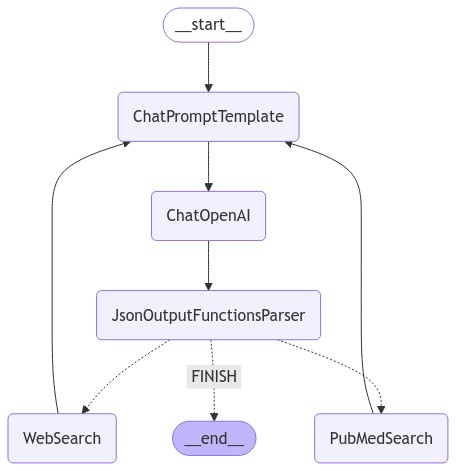

In [42]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [43]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ["WebSearch", "PubMedSearch"]
    }

    return results

In [44]:
research_chain = enter_chain | chain

In [46]:
for s in research_chain.stream(
    "Find out about carinogenic items."
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'WebSearch'}}
---


/opt/anaconda3/envs/medical_report_env/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'WebSearch': {'messages': [HumanMessage(content='Here are some insights into items that are considered carcinogenic:\n\n1. **Processed Meats**: The World Health Organization (WHO) classifies processed meat products as Group 1 carcinogens, meaning they are known to cause cancer. This classification is similar to that of tobacco smoking and asbestos exposure. Ingredients such as nitrates and nitrites used in meat processing can lead to the formation of cancer-causing chemicals.\n\n   - [Read more about processed meats](https://health.usnews.com/conditions/cancer/articles/worst-cancer-causing-foods)\n\n2. **Cooking Methods**: Overcooking foods, especially meats, can produce carcinogens. Cooking meat at high temperatures can create harmful substances like polycyclic aromatic hydrocarbons (PAHs) and heterocyclic amines (HCAs), which are linked to cancer.\n\n   - [Learn more about cooking and cancer risk](https://www.healthline.com/health/cancer/cancer-causing-foods)\n\n3. **Other Food Item

# Medical Report Writing Team

## Tool Creation

In [54]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
from langchain_core.tools import tool
import uuid
import os

os.makedirs('./medical_content/data', exist_ok=True)

def create_random_subdir():
    random_id = str(uuid.uuid4())[:8] # first 8 chars
    subdir_path = os.path.join('./medical_content/data', random_id)
    os.makedirs(subdir_path, exist_ok=True)
    return subdir_path

WORKING_DIR = Path(create_random_subdir())


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIR / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
):
    """Read the specified document."""
    with (WORKING_DIR / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIR / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIR / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIR / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [55]:
import operator
from pathlib import Path

class DocumentWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

In [56]:
def prelude(state):
    written_files = []
    if not WORKING_DIR.exists():
        WORKING_DIR.mkdir()
    
    try:
        written_files = [f.relative_to(WORKING_DIR) for f in WORKING_DIR.rglob("*")]
    
    except:
        pass

    if not written_files:
        return {**state, "current_files": "No files written."}

    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


## Agents and Nodes Creation

In [91]:
doc_writer_agent = create_agent(
    llm,
    [write_document, read_document, edit_document],
    ("You are an expert writing technical meteorological reports.\n"
    "Below are files currently in your directory:\n{current_files}"),
)

doc_writer_agent_with_context = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent = doc_writer_agent_with_context, name = "DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    ("You are an expert senior researcher tasked with writing a meteorological reports outline and"
    " taking notes to craft a meteorological reports.\n{current_files}"),
)
note_taking_agent_with_context = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent = note_taking_agent_with_context, name = "NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, read_document, edit_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)

copy_editor_agent_with_context = prelude | copy_editor_agent
copy_editor_node = functools.partial(
    agent_node, agent = copy_editor_agent_with_context, name = "CopyEditor"
)

In [92]:
doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker","CopyEditor"],
)

In [93]:
authoring_graph = StateGraph(DocumentWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editor_node)
authoring_graph.add_node("Supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "Supervisor")
authoring_graph.add_edge("NoteTaker", "Supervisor",)
authoring_graph.add_edge("CopyEditor", "Supervisor")

authoring_graph.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor": "CopyEditor",
        "FINISH": END
    }
)

authoring_graph.set_entry_point("Supervisor")
chain = authoring_graph.compile()

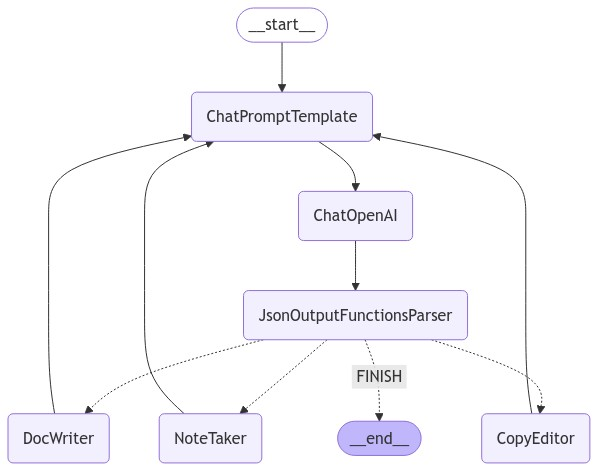

In [94]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [95]:
def enter_chain(
        message: str,
        members: List[str]
):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members)
    }

    return results

In [96]:
authoring_chain = (functools.partial(enter_chain, members = authoring_graph.nodes) | chain)

# Create Meta-Supervisor and Full Graph

In [97]:
llm = ChatOpenAI(model = "gpt-4o-mini")

In [98]:
supervisor_node = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH."),
    ["Medical Research Team", "Medical Report Team"],
)

In [99]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

In [100]:
super_graph = StateGraph(State)

super_graph.add_node("Medical Research Team", get_last_message | research_chain | join_graph)
super_graph.add_node("Medical Report Team", get_last_message | authoring_chain | join_graph)

super_graph.add_node("Supervisor", supervisor_node)

In [101]:
super_graph.add_edge("Medical Research Team", "Supervisor")
super_graph.add_edge("Medical Report Team", "Supervisor")
super_graph.add_conditional_edges(
    "Supervisor",
    lambda x: x["next"],
    {
        "Medical Research Team": "Medical Research Team",
        "Medical Report Team": "Medical Report Team",
        "FINISH": END,
    },
)

super_graph.set_entry_point("Supervisor")
super_graph = super_graph.compile()

In [104]:
def process_user_query(user_query: str) -> dict:
    """Wraps the user query with standard instructions for the system."""
    full_query = (f"{user_query} First consult the research team. "
                 "Then consult the report team and construct a well-structured report "
                 "with significant research findings.")
    
    return {
        "messages": [
            HumanMessage(content=full_query)
        ]
    }

In [105]:
for s in super_graph.stream(
    process_user_query("Write a report on carcinogenic items, foods and products we encounter in our daily lives, and offer some suggestions for avoiding such carcinogens."),
    {'recursion_limit' : 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'Medical Research Team'}}
---


/opt/anaconda3/envs/medical_report_env/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'Medical Research Team': {'messages': [HumanMessage(content='# Report on Carcinogenic Items, Foods, and Products in Daily Life\n\n## Introduction\nCarcinogens are substances that are known to cause cancer in humans. They can be found in various forms, including chemicals, foods, and products we encounter in our daily lives. Understanding these carcinogens is crucial for minimizing exposure and reducing cancer risk. This report aims to highlight common carcinogenic items, foods, and products and provide recommendations for avoiding them.\n\n## Common Carcinogenic Items in Daily Life\n\n### 1. Artificial Sweeteners\nRecent studies have raised concerns regarding artificial sweeteners like aspartame, which is commonly found in diet drinks and various processed foods. Health authorities have classified aspartame as possibly carcinogenic, although definitive evidence of its cancer-causing effects is still limited ([Harvard Health](https://www.health.harvard.edu/cancer/cancer-concerns-from-e